# Reinforcement Learning in Finite MDPs

The goal of this practical is to introduce the notions of RL, and implement the value iteration algorithm.

Note: this notebook is inspired from this github: https://github.com/rlgammazero/mvarl_hands_on, by Matteo Pirotta



In [ ]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt

import numpy as np


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **[Exercice 1]** Understanding Value-Function and Q-function

In this exercice, we are going to learn:

*   What is a MDP?
*   How to evaluate the quality of a policy in a MDP (Value-iteration and Policy-Iteration)
*   How to move from V-function to Q-function
*   How to move from Q-function to greedy-policy



## **[Step 1]** Dealing with MDP and RL environment

Here, we are going to use the cleaning robot MDP from
http://www.incompleteideas.net/sutton/book/first/3/node7.html

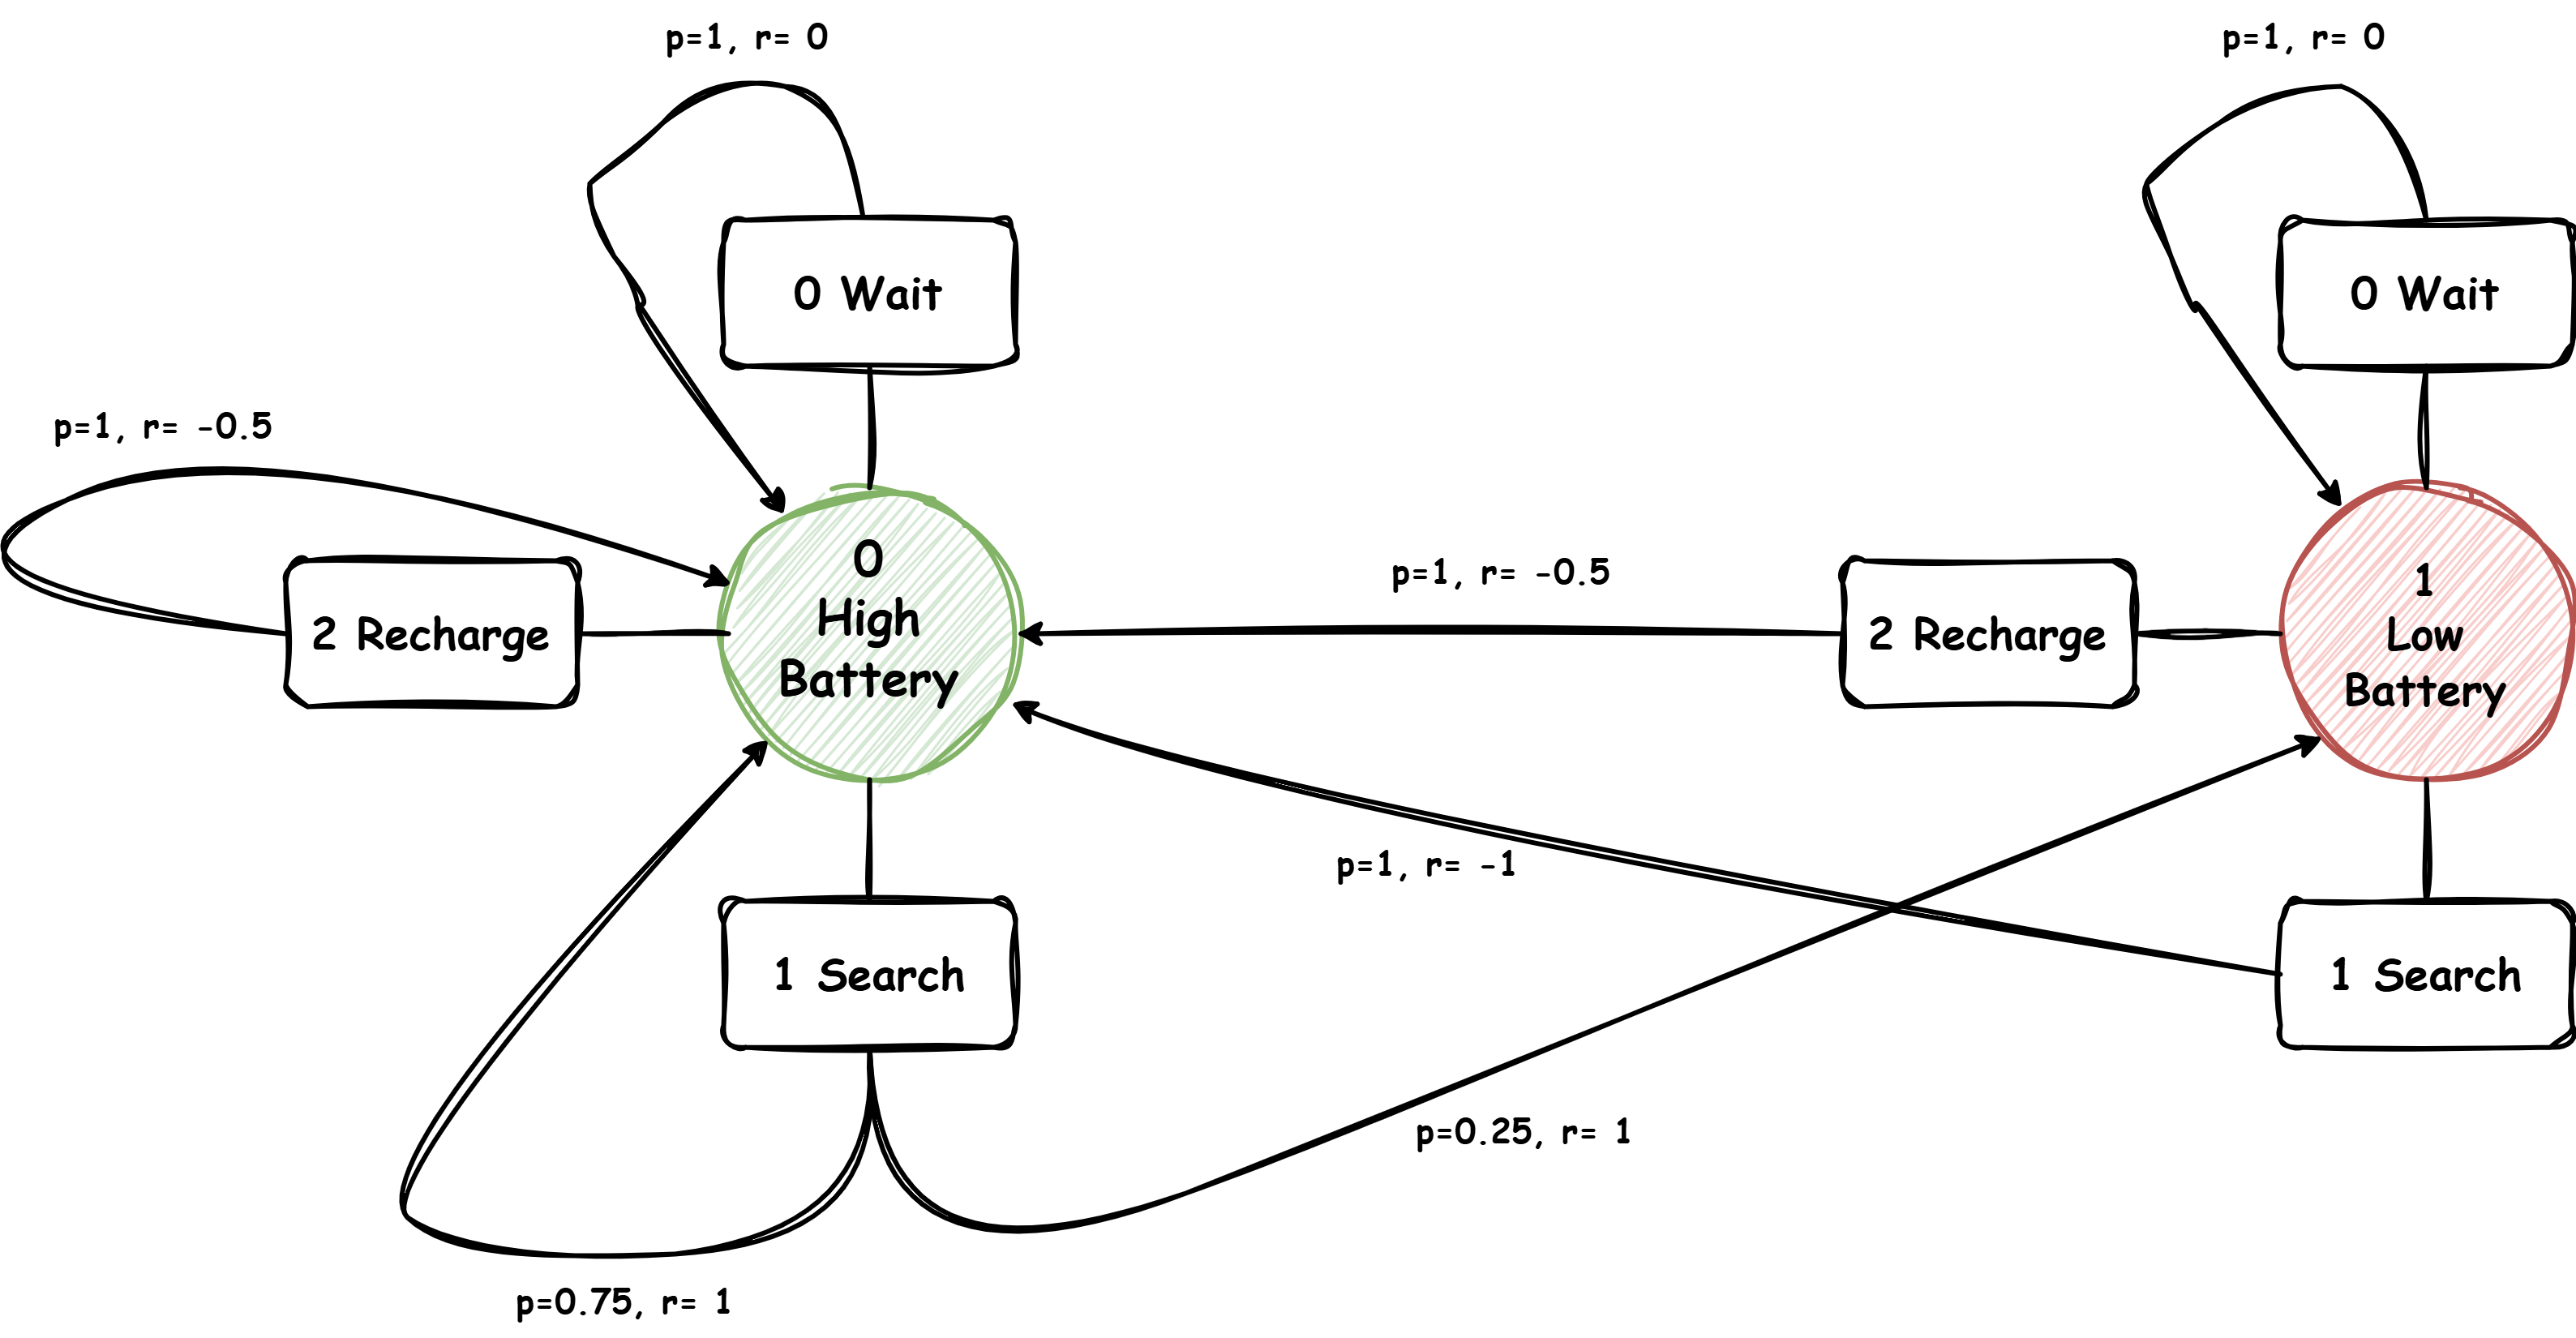

A MDP have is a tuple with ($S$, $A$, $R$, $P$, $\gamma$)
*   $S$ is the state space
*   $A$ is the action space
*   $R$ is the reward function
*   $P$ is the transition kernel. If I am in state $s$, and take the action $a$, what is the probability of moving to state $s'$
*   $\gamma$ is the discount factor, i.e., how far in the future you are looking for rewards (gamma=0 means, you just take immediate reward, gammma=0.9 you look at reward around 10 steps away)

**Preliminary questions:**

These questions are here to help you understand the coding questions that will come after.

1. Look at the transition graph above, which defines the MDP we are going to work on.

a. What is the state space $S$ and the action space $A$ ?

b. What do you think would be an optimal policy, a policy being "action I take in state 0, action I take in state 1" ? Why?

c. Imagine, we set $γ=0$, meaning we now focus only on immediate gains, how would your optimal policy change?

2. The Value of a state $s\in S$ under the policy $\pi$, denoted $V_\pi(s)$ is the expected gain of playing the policy $\pi$ starting from the state $s$:
$$V^\pi(s)= \mathbb{E}\big[ \sum_{t=0}^\infty \gamma^tr_t(s_t, a_t) \, \big | \, s_0=s, \, a_t=\pi(s_t), \, s_{t+1} \sim P(. | s_t, a_t) \big]$$

a. Consider the policy that always wait ($\pi_0: s ↦ 0$), what is $V^{\pi_0}(1)$ ?




**Additionnal Explanations and Reminders on RL**

For a given policy $\pi$, if we want to know if it's a good policy, we want to compute $V^\pi(s), \, \forall s \in S$, this is called **policy evaluation**. This is not always as easy as in the previous question.

Thankfully, Bellman equations are here to help us, this will be the subject of Questions 2, in the code below.

Another question is, can we find the optimal policy, i.e:
$$\pi^*, \; \forall s \in S, \, V^{\pi^*}(s) = \max_{ π \in Π}V^\pi(s)$$

Policy Improvement (slide 23 of Fabien's slides) is algorithm that can take a given policy, and improve its value, it is the subject of question 3.

The idea is as follows, start from a policy $\pi$ (whatever policy), compute $V^{\pi}$ using policy evaluation, and then deduce the Q-function $Q^\pi$, which is defined as: $Q^\pi(s,a)$ is the expected value when you start in state $s$ with action $a$ and then follow $\pi$

$$Q^\pi(s,a)= \mathbb{E}\big[ \sum_{t=0}^\infty \gamma^tr_t(s_t, a_t) \, \big | \, s_0=s, \, a_0=a, \, a_t=\pi(s_t), \, s_{t+1} \sim P(. | s_t, a_t) \big]$$

We have the following relation to deduce $Q$ from $V$:

$$Q^{\pi}(s, a) = R(s, a) + \gamma \sum_{s'} P(s, a, s')V^{\pi}(s') \text{ and from the definition above: } V^\pi(s) = Q^\pi(s, \pi(s))$$


And then take policy $\pi'$ that selects greedily the actions that maximize $Q^\pi$:

$$\pi'(s) = \mathrm{argmax}_{a\in A}(Q^\pi(s,a))$$

$\pi'$ is better than $\pi$ it is called policy improvement.

The intuition is that $Q^\pi(s,a)$ is the expected return when we start by taking the action $a$ instead of following the policy. So if it's a better choice to start by taking $a$ in state $s$ and then follow $\pi$, than just follow the policy from the beginning, it should always be better to take $a$ when encounter state $s$.

For the curious, you can find a proof in Sutton and Barto (the reference book for RL) : http://www.incompleteideas.net/book/first/ebook/node42.html



Another way to find the optimal policy is **Value iteration** (Question 4), the problem of the precedent method is it requires to inverse a lot of matrixes (to do the policy evaluation at each step) which is an operation in $O(S^3)$.

Another way to find the optimal policy is to rely on the Bellman equation. We define the optimal Bellman operator as:

$$\mathcal{T}: V \mapsto \Big(\mathcal{T}V: s ↦ \max_{a \in A} \big[R(s,a) + \gamma\sum_{s'}P(s,a,s')V(s)\big] \Big) $$

(operator on the space of functions from $S$ to $\mathbb{R}$)

Then the optimal value $V^*$ is the unique solution of the equation: $\mathcal{T}V = V$ (unique fixed point).

A solution to find $V^*$ is to start from a random $V_0$ and then compute $V_{k+1} = \mathcal{T}V_k$, we know (argument based on Banach's fixed point theorem) that the sequence converge towards $V^*$.

Once $V^*$ is found, then then we deduce $Q^*$ from the relation between $Q$ and $V$ and the optimal policy is:
$$\pi^*(s) = \mathrm{argmax}_{a\in A}(Q^*(s,a))$$


All the methods above rely on the fact that we know $P$ and $R$ in advance, another case of methods, named model-free RL, tries to find good policies without knowledge of P and R, this is the thema of exercice 2, where you will implement Q-learning.

The main idea is that know we don't know $P$ and $R$, but we just interact with the environment and collect tuples of the form: $(s_t, a_t, r_t, s_{t+1})$.

If we knew $P$ and $R$, we could use Bellman's equation:

$$V(s_t) = R(s_t,a_t) + \gamma\sum_{s'}P(s,a,s')V(s')$$

But if we have only $(s_t, a_t, r_t, s_{t+1})$, we would want to write:

$$V(s_t) ≈ r_t + \gamma V(s_{t+1})$$

Which isn't true, but inspired TD-learning (temporal difference), where we instantiate V with null values for each state, and then try to bring it closer to statisfying Bellman equation by doing the following operation at each timestep:

$$ V(s_t) ← (1-α) \times V(s_t) + α \times (r_t + \gamma V(s_{t+1})) $$

With $\alpha \in [0,1]$, for example $\alpha = 0.1$, by doing so we bring V a bit closer to Bellman equation at each step.

Q-learning follows the same principle, but instead on working with V it works with Q-functions.

In [ ]:
# @title **[Skip]** Robot MDP implementation

class RobotEnv:
    """
    Enviroment with 2 states and 3 actions
    Args:
        gamma (float): discount factor
        seed    (int): Random number generator seed
    """

    def __init__(self, gamma=0.5, seed=42):
        # Set seed
        self._RS = np.random.RandomState(seed)

        # Transition probabilities
        # shape (Ns, Na, Ns)
        # P[s, a, s'] = Prob(S_{t+1}=s'| S_t = s, A_t = a)

        self._Ns = 2
        self._Na = 3
        self._gamma = gamma

        # Note we add a recharge option in state A with a negative reward (to have a well defined matrix-transition)
        self._P = np.array([[[1, 0], [3/4, 1/4], [1, 0]], [[0,1],[1,0], [1,0]]])
        self._R = np.array([[0,1,-0.5], [0, -1, 0]])

        self._state_decoder  = {0: "High", 1: "Low"}
        self._action_decoder = {0: "WAIT", 1: "SEARCH", 2: "RECHARGE"}

        # Initialize base class
        self._states = np.arange(self.Ns).tolist()
        self._action_sets = [np.arange(self.Na).tolist()]*self.Ns

    ### Utils
    def render_state(self, state):
      return self._state_decoder[state]

    def render_action(self, action):
      return self._action_decoder[action]

    def render_policy(self, policy):
      if len(np.array(policy).shape) > 1:
        policy = densify_policy(policy)

      txt = ""
      for i, a in enumerate(policy):
        txt += "In state {} perform {}\n".format(self._state_decoder[i], self._action_decoder[a])
      return txt[:-1]

    ### MDP properties
    @property
    def states(self):
      return self._states

    @property
    def actions(self):
      return self._action_sets

    @property
    def transition_matrix(self):
      return self._P

    @property
    def reward_matrix(self):
      return self._R

    @property
    def gamma(self):
      return self._gamma

    @property
    def Ns(self):
      return self._Ns

    @property
    def Na(self):
      return self._Na

    ### Interact with environment
    def reward_func(self, state, action, *_):
      return self._R[state, action]

    def sample_transition(self, s, a):
        prob = self._P[s,a,:]
        next_s = self._RS.choice(self.states, p = prob)
        return next_s

    def reset(self, new_initial_state=0):
        assert new_initial_state < self.Ns
        self.state = new_initial_state
        return self.state

    def step(self, action):
        next_state = self.sample_transition(self.state, action)
        reward = self.reward_func(self.state, action, next_state)
        done = False
        info = {"str" : "In {} do {} arrive at {} get {}".format(
            self._state_decoder[state],
            self._action_decoder[action],
            self._state_decoder[next_state],
            reward )}
        self.state = next_state

        observation = next_state
        return observation, reward, done, info



In [ ]:
# create the environment
env = RobotEnv()

In [ ]:
# Display some of the MDP relevant information

print("Number of states: ", env.Ns, [env.render_state(s) for s in range(env.Ns)])
print("Number of actions: ", env.Na, [env.render_action(a) for a in range(env.Na)])
print("")
print("Set of states:", env.states)
print("Set of available actions per state:", env.actions)
print("")
print("P has shape: ", env.transition_matrix.shape)  # P[s'|s,a] = P[s, a, s'] = env.P[s, a, s']
print("R has shape: ", env.reward_matrix.shape)
print("discount factor: ", env.gamma)
print("")

A MDP is a mathematical representation of an environment. Here, we are going to interact with this environment.

In [ ]:
state=1
action=1
print(f"State {state}: battery is", env.render_state(state))
print(f"Action {action}: robot performs", env.render_action(action))
print(f"Reward at state={state} and action={action}) is", env.reward_func(state,action))

next_state = env.sample_transition(state,action)
print("Next (stochastic) state is", env.render_state(next_state))  # you can keep running this cell colab

Finally, we here define a helper to step in the environment. Let's try to follow a random policy by picking a random action $a$ at everytime step $t$.

In [ ]:
# Interact with environment

state = env.reset() # get initial state
print("initial state: ", state, ":", env.render_state(state))

print("")

# Interacting with the environment by tacking random action
print("s:   a:   s':   r:")
for time in range(15):
    action = np.random.randint(env.Na) # Pick random action
    next_state, reward, done, info = env.step(action)
    print(f"{state}    {action}    {next_state}    {reward} \t --> " + info["str"] if "str" in info else "")
    if done:
        print('You ran out of battery')
        break
    state = next_state
print("")


It is also possible to define a deterministic policy which associate an action $a$ for every state $s$

In [ ]:
# A random deterministic policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)
print(env.render_policy(policy))

### **[Question 1]** Handcrafting the optimal policy
Hand-craft the optimal policy (High=search, Low=recharge), display it, and interact with the environment for 5 steps


In [ ]:
my_policy = ...

# Interaction loop
state = env.reset() # get initial state
print("initial state: ", state, ":", env.render_state(state))

print("")

# Interacting with the environment by tacking random action
print("s:   a:   s':   r:")
for time in range(5):
    action = my_policy[state] # Pick action according to the policy
    next_state, reward, done, info = env.step(action)
    print(f"{state}    {action}    {next_state}    {reward} \t --> " + info["str"] if "str" in info else "")
    if done:
        break
    state = next_state
print("")

From now on, you should have understood how to interact with an environment, and retrieve the MDP information.




------------------------------

## **[Step 2]** Evaluating a policy
In this subsection, we aim at estimating the quality of a predefined policy, i.e, how much reward can I expect if I follow any policy (even if this policy is not optimal)



### Useful functions
In the following exercice, there is a constant back-and-forth between dense and sparse representation of policy. For instance, taking the action $a=2$ may be encoded by:

*   Sparse Represention: a=2
*   Dense Represention: a=[0, 0, 1]

To help you to move from dense and sparse, policy, we provide you those two functions:

In [ ]:
def densify_policy(policy, Na):
  """ Turn a sparse policy into a dense one.
  Ex: [0, 1], Na=2  -> [[1, 0, 0], [0, 1, 0]]
  """

  Ns = len(policy)
  dense_policy = np.zeros(shape=(Ns, Na))
  for i, a in enumerate(policy):
    dense_policy[i,a]=1
  return dense_policy

def sparsify_policy(policy):
  """ Turn a dense determinist policy into a sparse one.
  Ex: [[1, 0, 0], [0, 0, 1]] -> [0, 2]
  """
  return np.array(policy).argmax(axis=1)


### **[Question 2]** Policy Evaluation
Let's start doing things with our policy!

Compute the dynamics and rewards given the policy, and solve the linear system on V to evaluate the policy.

First, compute the policy normalized transition/rewards
$$P^{\pi}(s, s') = \sum_a{\pi(s|a)P(s,a,s')}$$
$$R^{\pi}(s) = \sum_a{\pi(s|a)R(s,a)}$$

Then, compute the value function, by solving Bellman equation,
$$V^{\pi} = R^{\pi} + \gamma P^{\pi}V^{\pi}$$

i.e.
$$V^{\pi} = (I - \gamma P^{\pi})^{-1} R^{\pi}$$

$$V^{\pi} = R^{\pi} + \gamma P^{\pi}V^{\pi}$$
$$V^{\pi} - \gamma P^{\pi}V^{\pi} = R^{\pi}$$
$$(I - \gamma P^{\pi})V^{\pi} = R^{\pi}$$
$$V^{\pi} = (I - \gamma P^{\pi})^{-1}R^{\pi}$$




$$(I - \gamma P^{\pi})V^{\pi} = R^{\pi}$$
$$A X = B$$ with $A = (I - \gamma P^{\pi})$, $X = V^\pi$ and $B = R^\pi$
What I want is to compute $X = A^{-1}B$


Hint for the computation of $P^\pi$ using the dense policy representation:

- We want $P^\pi$ to be of shape $S\times S$

- $\pi$ is of shape $S \times A$

- $P$ is of shape $S \times A \times S$

In [ ]:
# Policy evaluation (exact)
from typing import *

def build_Ppi_Rpi(my_env, sparse_policy) -> Tuple[np.ndarray, np.ndarray]:

  # Retrieve the environment MDP
  P = my_env.transition_matrix
  R = my_env.reward_matrix
  gamma = my_env.gamma

  dense_policy = densify_policy(sparse_policy, Na=env.Na)

  # Compute the dynamics given the policy
  Ppi = ...
  Rpi = ...

  return Ppi, Rpi

def build_Vpi(Ppi: np.ndarray,
            Rpi: np.ndarray,
            ) -> np.ndarray:
  # Evaluate the policy
  Vpi = ...

  return Vpi

In [ ]:
# Test your code !
sparse_policy = np.array([1, 0])  # sub-optinal policy... on purpose!

print("## pi:")
print(env.render_policy(sparse_policy))

Ppi, Rpi = build_Ppi_Rpi(env, sparse_policy)

print("Ppi", Ppi)
print("Rpi", Rpi)

Vpi = build_Vpi(Ppi, Rpi)

print("Vpi", Vpi)

### **[Question 2]** Implement the recursive implementation of value evaluation

You want to evaluate the policy by iterating the fixed point equation on V, starting from a randomly initialized V function.

In other words:

To compute the value function
$$V^{\pi} = R^{\pi} + \gamma P^{\pi}V^{\pi}$$

you can use the contractive property of Bellman
$$V^{\pi}_{k+1} = R^{\pi} + \gamma P^{\pi}V^{\pi}_k$$

In [ ]:
# Compute Value Iteration

# Stopping criterion
# Feel free to use the any valid stopping criterion (max_iteration or inf_norm)
epsilon = 1e-7

# Retrieving Ppr and Rpi using the function you built
Ppi, Rpi = build_Ppi_Rpi(env, sparse_policy)

def build_Vpi_iterative(Ppi: np.ndarray,
                        Rpi: np.ndarray,
                        epsilon: float,
                        ) -> np.ndarray:

  # Estimate V (please print v at each iteration k)
  v = np.zeros((Ppi.shape[0],))
  next_v = None
  while ...:
    if next_v is not None:
      v = next_v
    next_v = ...

  return next_v

Vpi = build_Vpi_iterative(Ppi, Rpi, epsilon)
print(build_Vpi_iterative(Ppi, Rpi, epsilon))

### **[Question 3]** Turning V-function into Q-function
What is the Q-function for this value function ?

$$Q^{\pi}(s, a) = R(s, a) + \gamma \sum_{s'} P(s, a, s')V^{\pi}(s')$$

In [ ]:
# Compute the Q values
Qpi = ...

print("## Qpi:")
print(Qpi)

The Q-function is a useful way to evaluate the policy. Yet, it can also be used to improve the policy! To do so, you can create a new policy by taking the argmax of the Q-function (improvment step).

What is the next policy?

In [ ]:
# Compute the Q values
print("## Qpi:")
print(Qpi)

# What is the next policy if we perform one step of policy improvment ?
new_policy = ...
print("## new pi:")
print(new_policy)
print(env.render_policy(new_policy))

# Compute the value of the NEW policy
new_dense_policy = densify_policy(new_policy, env.Na)

new_Ppi, new_Rpi = build_Ppi_Rpi(env, new_policy)
new_Vpi = build_Vpi(new_Ppi, new_Rpi)
print(new_Vpi)

## **[Step 3]** Policy Improvement in MDP

In slide 50-52, we introduced two algorithms to obtain the optimal policy from a sub-optimal one (by using different shade of policy improvment shapes).

*   **Policy iteration**: From an initial policy, compute its value exactly, then perform one step of greedy policy improvement.
*   **Value iteration**: From an initial policy, compute its value approximately, then perform one step of greedy policy improvement.


In [ ]:
# @title **[Skip]** New Environment


class GridWorldWithPits:
    def __init__(self, grid, txt_map, gamma=0.99, proba_succ=0.95, uniform_trans_proba=0.001, normalize_reward=False):
        self.desc = np.asarray(txt_map, dtype='c')
        self.grid = grid
        self.txt_map = txt_map

        self.action_names = np.array(['right', 'down', 'left', 'up'])

        self.n_rows, self.n_cols = len(self.grid), max(map(len, self.grid))

        # Create a map to translate coordinates [r,c] to scalar index
        # (i.e., state) and vice-versa
        self.normalize_reward = normalize_reward


        self.initial_state = None
        self.coord2state = np.empty_like(self.grid, dtype=int)
        self.nb_states = 0
        self.state2coord = []
        for i in range(self.n_rows):
            for j in range(len(self.grid[i])):
                if self.grid[i][j] != 'w':
                    if self.grid[i][j] == 's':
                        self.initial_state = self.nb_states
                    self.coord2state[i, j] = self.nb_states
                    self.nb_states += 1
                    self.state2coord.append([i, j])
                else:
                    self.coord2state[i, j] = -1

        self.P = None
        self.R = None
        self.proba_succ = proba_succ
        self.uniform_trans_proba = uniform_trans_proba

        # compute the actions available in each state
        self.state_actions = [range(len(self.action_names)) for _ in range(self.nb_states)]#self.compute_available_actions()
        self.matrix_representation()
        self.lastaction = None
        self.current_step = 0

        self._actions = self.state_actions
        self._gamma = gamma


    def matrix_representation(self):
        if self.P is None:
            nstates = self.nb_states
            nactions = max(map(len, self.state_actions))
            self.P = np.inf * np.ones((nstates, nactions, nstates))
            self.R = np.inf * np.ones((nstates, nactions))
            for s in range(nstates):
                r, c = self.state2coord[s]
                for a_idx, action in enumerate(range(len(self.action_names))):
                    self.P[s, a_idx].fill(0.)
                    if self.grid[r][c] == 'g':
                        self.P[s, a_idx, self.initial_state] = 1.
                        self.R[s, a_idx] = 10.
                    else:
                        ns_succ, ns_fail = np.inf, np.inf
                        if action == 0:
                            ns_succ = self.coord2state[r, min(self.n_cols - 1, c + 1)]
                            ns_fail = [self.coord2state[r, max(0, c - 1)],
                            self.coord2state[min(self.n_rows - 1, r + 1), c],
                            self.coord2state[max(0, r - 1), c]
                            ]

                        elif action == 1:
                            ns_succ = self.coord2state[min(self.n_rows - 1, r + 1), c]
                            ns_fail = [self.coord2state[max(0, r - 1), c],
                            self.coord2state[r, max(0, c - 1)],
                            self.coord2state[r, min(self.n_cols - 1, c + 1)]
                            ]
                        elif action == 2:
                            ns_succ = self.coord2state[r, max(0, c - 1)]
                            ns_fail = [self.coord2state[r, min(self.n_cols - 1, c + 1)],
                            self.coord2state[max(0, r - 1), c],
                            self.coord2state[min(self.n_rows - 1, r + 1), c]
                            ]
                        elif action == 3:
                            ns_succ = self.coord2state[max(0, r - 1), c]
                            ns_fail = [self.coord2state[min(self.n_rows - 1, r + 1), c],
                            self.coord2state[r, min(self.n_cols - 1, c + 1)],
                            self.coord2state[r, max(0, c - 1)]
                            ]

                        L = []
                        for el in ns_fail:
                            x, y = self.state2coord[el]
                            if self.grid[x][y] == 'w':
                                L.append(s)
                            else:
                                L.append(el)

                        self.P[s, a_idx, ns_succ] = self.proba_succ
                        for el in L:
                            self.P[s, a_idx, el] += (1. - self.proba_succ)/len(ns_fail)
                        # self.P[s, a_idx] = self.P[s, a_idx] + self.uniform_trans_proba / nstates
                        # self.P[s, a_idx] = self.P[s, a_idx] / np.sum(self.P[s, a_idx])

                        assert np.isclose(self.P[s, a_idx].sum(), 1)

                        if self.grid[r][c] == 'x':
                            self.R[s, a_idx] = -20
                        else:
                            self.R[s, a_idx] = -2

            if self.normalize_reward:
                minr = np.min(self.R)
                maxr = np.max(self.R[np.isfinite(self.R)])
                self.R = (self.R - minr) / (maxr - minr)

            self.d0 = np.zeros((nstates,))
            self.d0[self.initial_state] = 1.

    def compute_available_actions(self):
        # define available actions in each state
        # actions are indexed by: 0=right, 1=down, 2=left, 3=up
        state_actions = []
        for i in range(self.n_rows):
            for j in range(self.n_cols):
                if self.grid[i][j] == 'g':
                    state_actions.append([0])
                elif self.grid[i][j] != 'w':
                    actions = [0, 1, 2, 3]
                    if i == 0:
                        actions.remove(3)
                    if j == self.n_cols - 1:
                        actions.remove(0)
                    if i == self.n_rows - 1:
                        actions.remove(1)
                    if j == 0:
                        actions.remove(2)

                    for a in copy.copy(actions):
                        r, c = i, j
                        if a == 0:
                            c = min(self.n_cols - 1, c + 1)
                        elif a == 1:
                            r = min(self.n_rows - 1, r + 1)
                        elif a == 2:
                            c = max(0, c - 1)
                        else:
                            r = max(0, r - 1)
                        if self.grid[r][c] == 'w':
                            actions.remove(a)

                    state_actions.append(actions)
        return state_actions

    def description(self):
        desc = {
            'name': type(self).__name__
        }
        return desc

    def reward_func(self, state, action, next_state):
        return self.R[state, action]

    def reset(self, s=None):
        self.lastaction = None
        if s is None:
            self.state = self.initial_state
        else:
            self.state = s
        self.current_step = 0
        return self.state

    def step(self, action):
        try:
            action_index = self.state_actions[self.state].index(action)
        except:
            raise ValueError("Action {} cannot be executed in this state {}".format(action, self.state))

        p = self.P[self.state, action_index]
        next_state = np.random.choice(self.nb_states, 1, p=p).item()

        reward = self.R[self.state, action_index]

        self.lastaction = action

        r, c = self.state2coord[self.state]
        done = self.grid[r][c] == 'g'
        self.current_step +=1
        self.state = next_state

        return next_state, reward, done, {}

    def render_state(self, state):

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        r, c = self.state2coord[state]

        def ul(x):
            return "_" if x == " " else x

        if self.grid[r][c] == 'x':
            out[1 + r][2 * c + 1] = utils.colorize(out[1 + r][2 * c + 1], 'red', highlight=True)
        elif self.grid[r][c] == 'g':  # passenger in taxi
            out[1 + r][2 * c + 1] = utils.colorize(ul(out[1 + r][2 * c + 1]), 'green', highlight=True)
        else:
            out[1 + r][2 * c + 1] = utils.colorize(ul(out[1 + r][2 * c + 1]), 'yellow', highlight=True)

        return "\n".join(["".join(row) for row in out]) + "\n"

    def render_action(self, action):
      return self.action_names[action]

    def render_policy(self, pol):
        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        r, c = self.state2coord[self.state]

        for s in range(self.Ns):
            r, c = self.state2coord[s]
            action = pol[s]
            # 'right', 'down', 'left', 'up'
            if action == 0:
                out[1 + r][2 * c + 1] = '>'
            elif action == 1:
                out[1 + r][2 * c + 1] = 'v'
            elif action == 2:
                out[1 + r][2 * c + 1] = '<'
            elif action == 3:
                out[1 + r][2 * c + 1] = '^'
            else:
                raise ValueError()

        return "\n".join(["".join(row) for row in out]) + "\n"

    def copy(self):
        new_env = GridWorldWithPits(grid=self.grid, txt_map=self.txt_map,
                                    proba_succ=self.proba_succ, uniform_trans_proba=self.uniform_trans_proba)
        return new_env

    def sample_transition(self, s, a):
        try:
            p = self.P[s, a]
        except:
            raise ValueError("Action {} cannot be executed in this state {}".format(action, self.state))
        next_state = np.random.choice(self.nb_states, 1, p=p).item()

    ### MDP properties
    @property
    def states(self):
      return np.zeros([self.n_cols, self.n_rows])

    @property
    def actions(self):
      return range(4)

    @property
    def transition_matrix(self):
      return self.P

    @property
    def reward_matrix(self):
      return self.R

    @property
    def gamma(self):
      return self._gamma

    @property
    def Ns(self):
      return self.n_cols * self.n_rows

    @property
    def Na(self):
      return 4

The environment works as follow:

*   At each timestep, you have a negative reward of -2
*   If the agent moves to state labelled with X, it receives a negative reward of -20
*   If the agent moves to the state labelled with G (goal), it receives a reward of 10, and the trajectory ends




In [ ]:
#@title New Maze environment
# s: start
# g: goal
# x: negative reward state

grid1 = [
    ['', '', '', 'g'],
    ['', 'x', '', ''],
    ['s', '', '', '']
]
grid1_MAP = [
    "+-------+",
    "| : : :G|",
    "| :x: : |",
    "|S: : : |",
    "+-------+",
]

env = GridWorldWithPits(grid=grid1, txt_map=grid1_MAP, uniform_trans_proba=0)

In [ ]:
#@title Relevant information about the environment
# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.transition_matrix.shape)  # P[s'|s,a] = P[s, a, s'] = env.P[s, a, s']
print("R has shape: ", env.reward_matrix.shape)
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=0, a=1,s'=1): ", env.reward_func(0,1,1))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")

In [ ]:
#@title Definining and running a random policy
# Define a fixed random policy
sparse_policy = np.random.randint(env.Na, size = (env.Ns,))
print(env.render_policy(sparse_policy))

# Start a new episode
state = env.reset()
print("start:")
print(env.render_state(state))

# Follow the policy
for i in range(5):
    action = sparse_policy[state]
    state, reward, done, _ = env.step(action)
    print(action, ":", env.render_action(action))
    print(env.render_state(state))
    if done:
      break


In [ ]:
#@title Utility functions
# useful function
def plot_infnorm(all_v, v_star, name):
  """Print the infinite norm between computed vs and v_star (to get learning progress)."""

  all_v = np.array(all_v)
  v_star = np.array(v_star)

  # Compute inf norm
  diff = np.absolute(all_v - v_star).max(axis=1)

  plt.plot(diff)
  plt.xlabel('Iteration')
  plt.ylabel('Error')
  plt.title(name)



### **[Question 4]** Implement Value Iteration

In [ ]:
# Compute Policy Iteration

env.reset()

# Retrieve the environment MDP
P = env.transition_matrix
R = env.reward_matrix
gamma = env.gamma

# Prepare v, and storage
v_all = []

sparse_policy = np.zeros(shape=(env.Ns,), dtype=np.int32) + 2
sparse_policy_all = []

# iterate over the value
while True:

  print(env.render_policy(sparse_policy))

  # Densify policy to perform matrix operation
  dense_policy = densify_policy(sparse_policy, Na=env.Na)

  # Perform your step of policy iteration here
  Ppi = ...
  Rpi = ...
  Vpi = ...
  Qpi = ...
  new_sparse_policy = ...

  # store v
  v_all.append(Vpi)
  sparse_policy_all.append(new_sparse_policy)
  print(env.render_policy(new_sparse_policy))

  # stopping criterion
  if ...:
    break

  sparse_policy = new_sparse_policy


# Display final results
print("  ###  Final results  ###")
print(env.render_policy(new_sparse_policy))
plot_infnorm(sparse_policy_all, new_sparse_policy, name="Pi")

In [ ]:
# Start a new episode
state = env.reset()
print("start:")
print(env.render_state(state))

# Follow the policy
for i in range(10):
    action = new_sparse_policy[state]
    state, reward, done, _ = env.step(action)
    print(action, ":", env.render_action(action))
    print(env.render_state(state))
    if done:
      break


# **[Exercice 2]** Q learning
Q learning is a **model-free** algorithm for estimating the optimal Q-function **online**.

Being **model-free** means that it doesn't assume knowledge of $P$ and $r$, only that we can interact with the environment.

Being **online** means that we update, and hopefully improve our
policy with each step that we are making in the environment.

It is an **off-policy** algorithm. This means that the samples we use to update our **learnt** policy are collected with an **acting**  policy that is (potentially) not the **learnt** one, and not the one associated to the estimated Q-function.

Q-learning works as follows:
- **Initialization**: Initialize a current estimated Q-function $Q$ to $0$. Receive an initial state $s$ from the environment.
- **Iterate**:
  -  Pick an action according to an $\varepsilon$-greedy version of the argmax policy on $Q$, i.e. with probability $\varepsilon$, pick a random uniform action, with probability $1 - \varepsilon$, pick the argmax of $Q(s, a)$.
  - Observe the next state $s'$ and new reward $r$.
  - Update $Q$ using the quadruplet $(s, a, r, s')$ with learning rate $\alpha$
  $$Q(s, a) \leftarrow (1 - \alpha) Q(s, a) + \alpha (r + \gamma \max\limits_{a'} Q(s', a'))$$

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the cumulative sum of rewards

In [ ]:
# main algorithmic loop
state = env.reset()
t = 0
max_steps = 50000  # Increasee this number when it works for full convergence
all_rewards = []
all_q_function = []

# Training values
epsilon = 0.05
alpha = 0.1

# Initialize the Q-Function here
q_function = ...

while t < max_steps:

    # Sample the action (epsilon greedy)
    action = ...

    # Sample the environment
    next_state, reward, done, info = env.step(action)

    # Update q-function
    q_function[...] = ...

    # Store information
    all_rewards.append(reward)
    all_q_function.append(np.copy(q_function))

    state = next_state
    if done:
      state = env.reset()

    # iterate
    t = t + 1

sparse_policy = q_function.argmax(axis=1)
print(env.render_policy(sparse_policy))

In [ ]:
#@title Plotting evolution of the reward across time
average_rewards = np.convolve(all_rewards, np.ones(150)/150, mode='valid')  # average rewards over 100 steps
plt.figure()
plt.plot(average_rewards)
plt.xlabel('Iteration')
plt.ylabel('rewards')
# Now you have to implement the cumulative rewards :)

In [ ]:
#@title Plotting evolution of the q value across time
state=1 #@param
action=1 #@param
one_q = [q[state, action] for q in all_q_function]
average_q_values = np.convolve(one_q, np.ones(100)/100, mode='valid')  # average rewards over 100 steps
plt.figure()
plt.plot(average_q_values)
plt.xlabel('Iteration')
plt.ylabel(f'q[{state}, {action}]')
# Now you have to implement the Q error :)

In [ ]:
#@title Running the agent:
state = env.reset()
env.render_state(state)
rewards = []
for i in range(30):
    action = sparse_policy[state]
    print(env.render_action(action))
    state, reward, done, _ = env.step(action)
    if done:
      state = env.reset()
    print(env.render_state(state))